# Midterm machine learning 

In [166]:
## Imports
import torch
import torch.nn as nn
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [167]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Load data 

In [168]:
dataset = MNIST(root = 'data/', download = True)
print(len(dataset))

60000


## Overview data

Label: 1


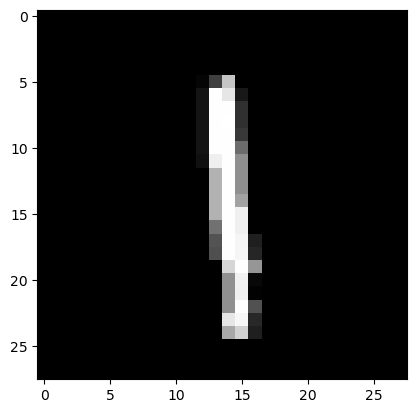

In [169]:
image, label = dataset[8]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [170]:
## MNIST dataset(images and labels) - Training data 
mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
print(mnist_dataset)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [171]:
image_tensor, label = mnist_dataset[8] 
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 1


In [172]:
print(image_tensor[:,10:15,10:15])
print(torch.max(image_tensor), torch.min(image_tensor))

tensor([[[0.0000, 0.0000, 0.0784, 0.9961, 0.9961],
         [0.0000, 0.0000, 0.0627, 0.9373, 0.9961],
         [0.0000, 0.0000, 0.0000, 0.6980, 0.9961],
         [0.0000, 0.0000, 0.0000, 0.6980, 0.9961],
         [0.0000, 0.0000, 0.0000, 0.6980, 0.9961]]])
tensor(1.) tensor(0.)


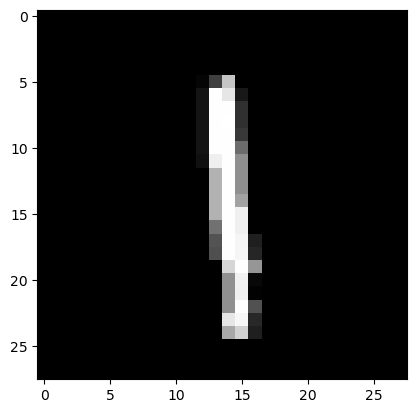

In [173]:
## Plot the image of the tensor
plt.imshow(image_tensor[0,:,:],cmap = 'gray')

## Training and validation datasets

- Training set - The part of the data will be used to train the model,compute the loss and adjust the weights of the model using gradient descent.
- Validation set - This part of the dataset will be used to evalute the traing model, adjusting the hyperparameters and pick the best version of the model.
- Test set - This part of the dataset is used to final check the model predictions on the new unseen data to evaluate how well the model is performing.


In [174]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  50000
length of Validation Datasets:  10000


In [175]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [176]:
n_iters = 3000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

7


## Model simple

## Model feed forward Nerual Network

In [1]:
# Define accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [177]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function 1: input_dim --> hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.sigmoid = nn.Sigmoid()

        # Linear function 2 (readout): hidden_dim --> output_dim
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        
        # Non-linearity
        out = self.sigmoid(out)
        
        # Linear function 2 (readout)
        out = self.fc2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        images = images.reshape(-1, 784).to(device)  # Flatten the images and move to device
        labels = labels.to(device)  # Move labels to device
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.reshape(-1, 784).to(device)  # Flatten the images and move to device
        labels = labels.to(device)  # Move labels to device
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

In [178]:

# Evaluate function
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Fit function
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()  # Set the model to training mode
        train_losses = []
        train_accs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            result = evaluate(model, val_loader)
        
        # Calculate average training loss and accuracy
        train_loss = torch.stack(train_losses).mean().item()
        train_acc = torch.stack(train_accs).mean().item()
        
        result['train_loss'] = train_loss
        result['train_acc'] = train_acc
        
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [179]:
def extractAccuracyLoss(history):
    train_accuracies = [result['train_acc'] for result in history]
    val_accuracies = [result['val_acc'] for result in history]
    train_losses = [result['train_loss'] for result in history]
    val_losses = [result['val_loss'] for result in history]
    return train_accuracies, val_accuracies, train_losses, val_losses


def plotAccLoss(history):
    train_accuracies, val_accuracies, train_losses, val_losses = extractAccuracyLoss(history)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training')
    plt.plot(val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [180]:
# Instantiate the model
input_dim = 28*28 # size image = 724
hidden_dim = 100
output_dim = 10     # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)

In [181]:
model

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [182]:
# epoch, lr, model, train, val, optimization
history1 = fit(5, 0.001, model, train_loader, val_loader, opt_func=torch.optim.SGD)

Epoch [0], train_loss: 2.3061, train_acc: 0.1157, val_loss: 2.2942, val_acc: 0.1325
Epoch [1], train_loss: 2.2889, train_acc: 0.1705, val_loss: 2.2824, val_acc: 0.1638
Epoch [2], train_loss: 2.2778, train_acc: 0.1738, val_loss: 2.2721, val_acc: 0.1909
Epoch [3], train_loss: 2.2675, train_acc: 0.2203, val_loss: 2.2619, val_acc: 0.2427
Epoch [4], train_loss: 2.2571, train_acc: 0.2521, val_loss: 2.2515, val_acc: 0.3086


In [183]:
history1

[{'val_loss': 2.2941510677337646,
  'val_acc': 0.1325158178806305,
  'train_loss': 2.306123971939087,
  'train_acc': 0.11573290079832077},
 {'val_loss': 2.2823708057403564,
  'val_acc': 0.1637658178806305,
  'train_loss': 2.2888987064361572,
  'train_acc': 0.17047233879566193},
 {'val_loss': 2.2721474170684814,
  'val_acc': 0.19086234271526337,
  'train_loss': 2.2778244018554688,
  'train_acc': 0.17379315197467804},
 {'val_loss': 2.2619073390960693,
  'val_acc': 0.24268196523189545,
  'train_loss': 2.2675042152404785,
  'train_acc': 0.22034446895122528},
 {'val_loss': 2.251528263092041,
  'val_acc': 0.3086431920528412,
  'train_loss': 2.257087469100952,
  'train_acc': 0.2520899772644043}]

In [184]:
history2 = fit(5, 0.001, model, train_loader, val_loader, opt_func=torch.optim.SGD)

Epoch [0], train_loss: 2.2465, train_acc: 0.3149, val_loss: 2.2408, val_acc: 0.3516
Epoch [1], train_loss: 2.2357, train_acc: 0.3556, val_loss: 2.2298, val_acc: 0.3868
Epoch [2], train_loss: 2.2245, train_acc: 0.3981, val_loss: 2.2184, val_acc: 0.4085
Epoch [3], train_loss: 2.2128, train_acc: 0.4150, val_loss: 2.2066, val_acc: 0.4373
Epoch [4], train_loss: 2.2008, train_acc: 0.4567, val_loss: 2.1943, val_acc: 0.4509


In [185]:
history3 = fit(5, 0.001, model, train_loader, val_loader, opt_func=torch.optim.SGD)

Epoch [0], train_loss: 2.1883, train_acc: 0.4720, val_loss: 2.1815, val_acc: 0.4698
Epoch [1], train_loss: 2.1752, train_acc: 0.4846, val_loss: 2.1681, val_acc: 0.4983
Epoch [2], train_loss: 2.1615, train_acc: 0.5056, val_loss: 2.1542, val_acc: 0.5157
Epoch [3], train_loss: 2.1472, train_acc: 0.5216, val_loss: 2.1395, val_acc: 0.5332
Epoch [4], train_loss: 2.1322, train_acc: 0.5372, val_loss: 2.1242, val_acc: 0.5503


## Model using model 3 layer - gradient, gradient mome, Adagrad, RMSprop, Adam

In [186]:
# Parameter
EPOCH = 10
LR = 0.001
input_dim = 28*28 # size image = 724
hidden_dim = 100
output_dim = 10     # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

### SGD

In [187]:
model1_SGD = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)

In [188]:
history1_SGD = fit(EPOCH, LR, model1_SGD, train_loader, val_loader, opt_func=torch.optim.SGD)

Epoch [0], train_loss: 2.3177, train_acc: 0.1058, val_loss: 2.2992, val_acc: 0.1189
Epoch [1], train_loss: 2.2905, train_acc: 0.2024, val_loss: 2.2842, val_acc: 0.2750
Epoch [2], train_loss: 2.2786, train_acc: 0.2384, val_loss: 2.2738, val_acc: 0.1922
Epoch [3], train_loss: 2.2686, train_acc: 0.1957, val_loss: 2.2639, val_acc: 0.2482
Epoch [4], train_loss: 2.2587, train_acc: 0.2504, val_loss: 2.2540, val_acc: 0.3033
Epoch [5], train_loss: 2.2486, train_acc: 0.3098, val_loss: 2.2438, val_acc: 0.3549
Epoch [6], train_loss: 2.2383, train_acc: 0.3753, val_loss: 2.2333, val_acc: 0.3778
Epoch [7], train_loss: 2.2277, train_acc: 0.4025, val_loss: 2.2225, val_acc: 0.4157
Epoch [8], train_loss: 2.2166, train_acc: 0.4177, val_loss: 2.2113, val_acc: 0.4613
Epoch [9], train_loss: 2.2053, train_acc: 0.4737, val_loss: 2.1996, val_acc: 0.4773


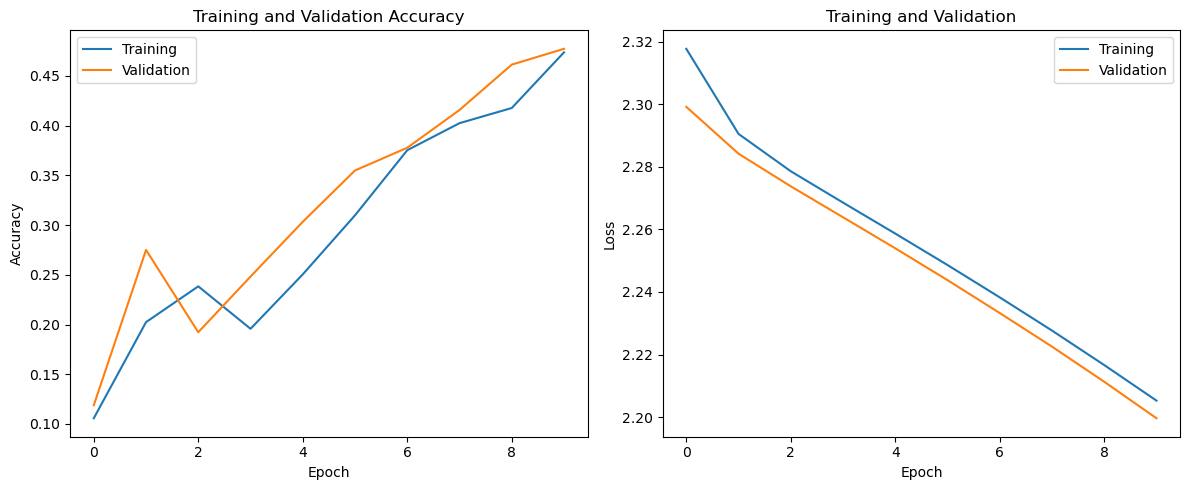

In [189]:
# Plotting accuracy
plotAccLoss(history1_SGD)

### Momentum

In [190]:
from torch.optim import SGD

In [191]:
model1_momentum = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)

In [192]:
history_momentumSGD = fit(EPOCH, LR, model1_momentum, train_loader, val_loader, 
                          opt_func=lambda params, lr: SGD(params, lr=lr, momentum=0.9))

Epoch [0], train_loss: 2.2538, train_acc: 0.2800, val_loss: 2.1987, val_acc: 0.4586
Epoch [1], train_loss: 2.1290, train_acc: 0.4986, val_loss: 2.0478, val_acc: 0.5965
Epoch [2], train_loss: 1.9403, train_acc: 0.6036, val_loss: 1.8233, val_acc: 0.6288
Epoch [3], train_loss: 1.6918, train_acc: 0.6669, val_loss: 1.5622, val_acc: 0.6820
Epoch [4], train_loss: 1.4386, train_acc: 0.7163, val_loss: 1.3250, val_acc: 0.7290
Epoch [5], train_loss: 1.2262, train_acc: 0.7529, val_loss: 1.1382, val_acc: 0.7697
Epoch [6], train_loss: 1.0625, train_acc: 0.7844, val_loss: 0.9966, val_acc: 0.7860
Epoch [7], train_loss: 0.9388, train_acc: 0.8027, val_loss: 0.8888, val_acc: 0.8086
Epoch [8], train_loss: 0.8440, train_acc: 0.8172, val_loss: 0.8054, val_acc: 0.8242
Epoch [9], train_loss: 0.7705, train_acc: 0.8284, val_loss: 0.7411, val_acc: 0.8340


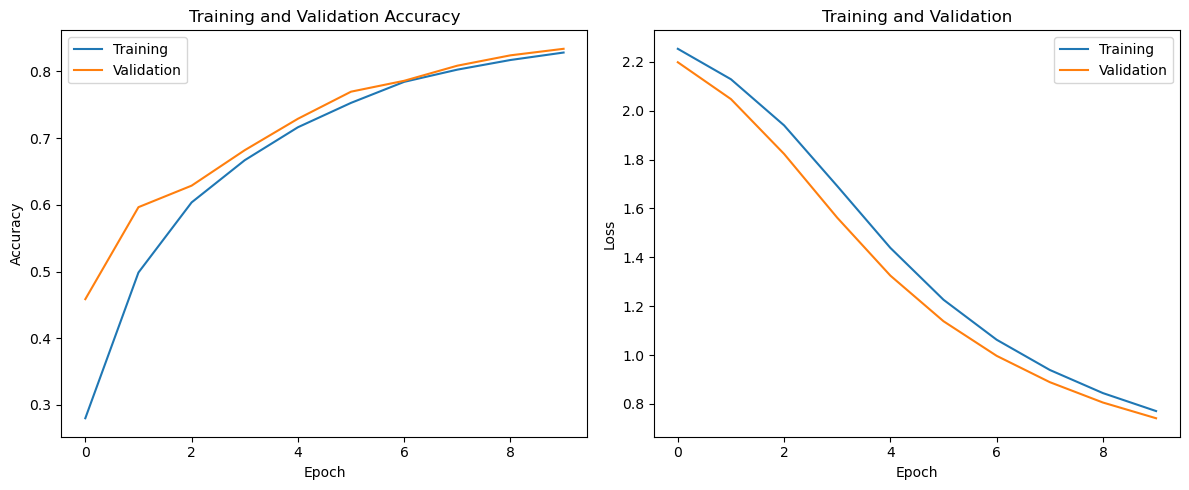

In [193]:
plotAccLoss(history_momentumSGD)

### Adam

In [194]:
model1_Adam = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)

In [195]:
history_Adam = fit(EPOCH, LR, model1_Adam, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 0.8032, train_acc: 0.8254, val_loss: 0.3611, val_acc: 0.9044
Epoch [1], train_loss: 0.3071, train_acc: 0.9154, val_loss: 0.2650, val_acc: 0.9270
Epoch [2], train_loss: 0.2415, train_acc: 0.9311, val_loss: 0.2271, val_acc: 0.9370
Epoch [3], train_loss: 0.2054, train_acc: 0.9414, val_loss: 0.2009, val_acc: 0.9437
Epoch [4], train_loss: 0.1797, train_acc: 0.9489, val_loss: 0.1818, val_acc: 0.9505
Epoch [5], train_loss: 0.1597, train_acc: 0.9542, val_loss: 0.1655, val_acc: 0.9546
Epoch [6], train_loss: 0.1433, train_acc: 0.9592, val_loss: 0.1544, val_acc: 0.9568
Epoch [7], train_loss: 0.1296, train_acc: 0.9628, val_loss: 0.1438, val_acc: 0.9601
Epoch [8], train_loss: 0.1172, train_acc: 0.9663, val_loss: 0.1347, val_acc: 0.9623
Epoch [9], train_loss: 0.1068, train_acc: 0.9697, val_loss: 0.1276, val_acc: 0.9634


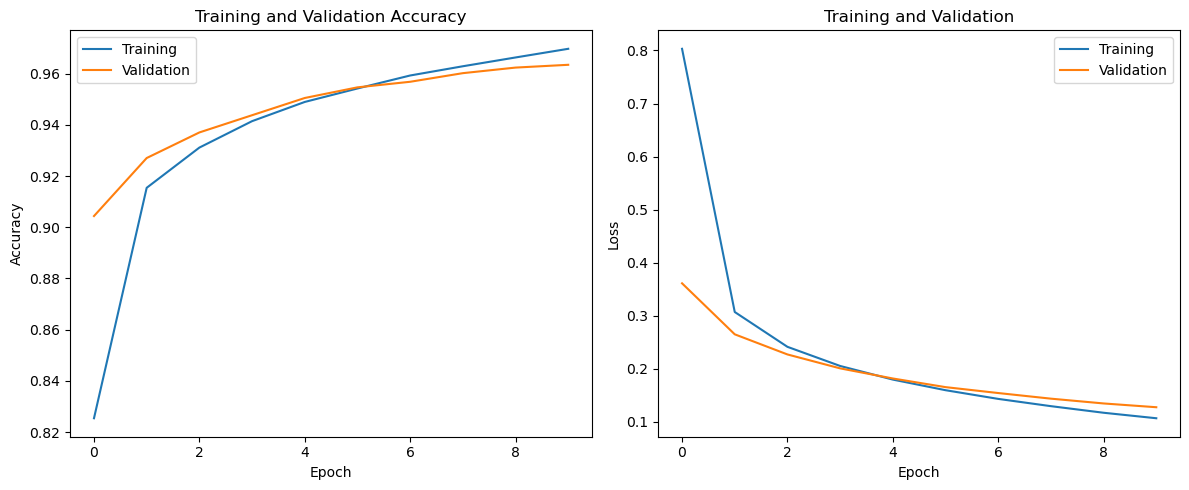

In [196]:
plotAccLoss(history_Adam)

### RMSprop

In [197]:
model1_RMSpro = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)

In [198]:
history1_RMSproop = fit(EPOCH, LR, model1_RMSpro, train_loader, val_loader, opt_func=torch.optim.RMSprop)

Epoch [0], train_loss: 0.5566, train_acc: 0.8677, val_loss: 0.3243, val_acc: 0.9106
Epoch [1], train_loss: 0.2781, train_acc: 0.9206, val_loss: 0.2466, val_acc: 0.9304
Epoch [2], train_loss: 0.2240, train_acc: 0.9356, val_loss: 0.2141, val_acc: 0.9389
Epoch [3], train_loss: 0.1907, train_acc: 0.9457, val_loss: 0.1888, val_acc: 0.9465
Epoch [4], train_loss: 0.1660, train_acc: 0.9524, val_loss: 0.1697, val_acc: 0.9525
Epoch [5], train_loss: 0.1464, train_acc: 0.9583, val_loss: 0.1553, val_acc: 0.9555
Epoch [6], train_loss: 0.1304, train_acc: 0.9627, val_loss: 0.1444, val_acc: 0.9594
Epoch [7], train_loss: 0.1172, train_acc: 0.9667, val_loss: 0.1311, val_acc: 0.9622
Epoch [8], train_loss: 0.1062, train_acc: 0.9696, val_loss: 0.1243, val_acc: 0.9643
Epoch [9], train_loss: 0.0964, train_acc: 0.9731, val_loss: 0.1189, val_acc: 0.9657


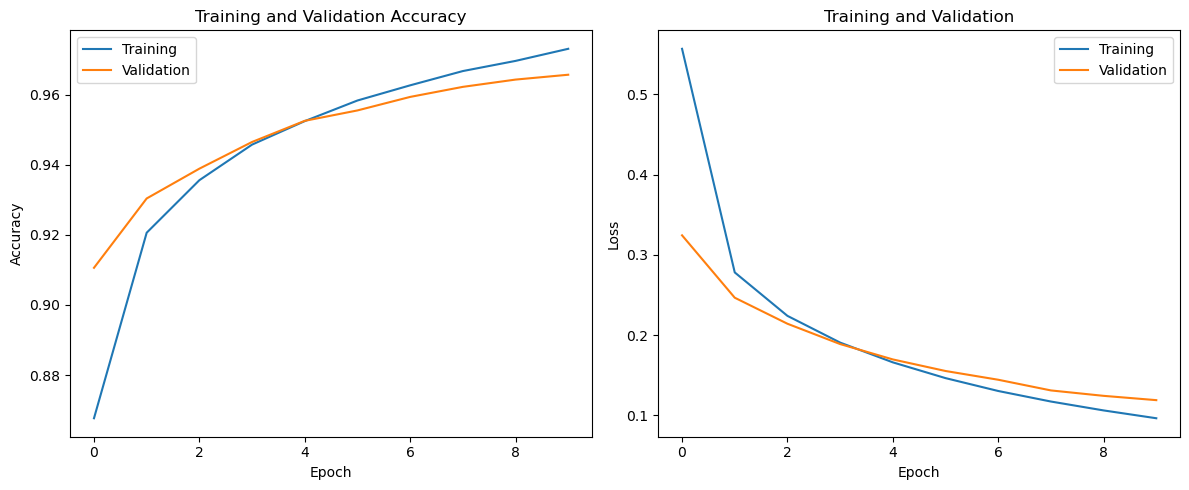

In [199]:
plotAccLoss(history1_RMSproop)

### Adagrad

In [200]:
model1_Adagrad = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim).to(device)

In [201]:
history1_Adagrad = fit(EPOCH, LR, model1_Adagrad, train_loader, val_loader, opt_func=torch.optim.Adagrad)

Epoch [0], train_loss: 1.8871, train_acc: 0.6741, val_loss: 1.6610, val_acc: 0.7384
Epoch [1], train_loss: 1.5266, train_acc: 0.7600, val_loss: 1.4103, val_acc: 0.7658
Epoch [2], train_loss: 1.3265, train_acc: 0.7835, val_loss: 1.2488, val_acc: 0.7918
Epoch [3], train_loss: 1.1903, train_acc: 0.8016, val_loss: 1.1329, val_acc: 0.8095
Epoch [4], train_loss: 1.0897, train_acc: 0.8138, val_loss: 1.0448, val_acc: 0.8223
Epoch [5], train_loss: 1.0114, train_acc: 0.8241, val_loss: 0.9750, val_acc: 0.8303
Epoch [6], train_loss: 0.9484, train_acc: 0.8334, val_loss: 0.9178, val_acc: 0.8377
Epoch [7], train_loss: 0.8962, train_acc: 0.8393, val_loss: 0.8699, val_acc: 0.8431
Epoch [8], train_loss: 0.8521, train_acc: 0.8451, val_loss: 0.8293, val_acc: 0.8481
Epoch [9], train_loss: 0.8145, train_acc: 0.8489, val_loss: 0.7941, val_acc: 0.8527


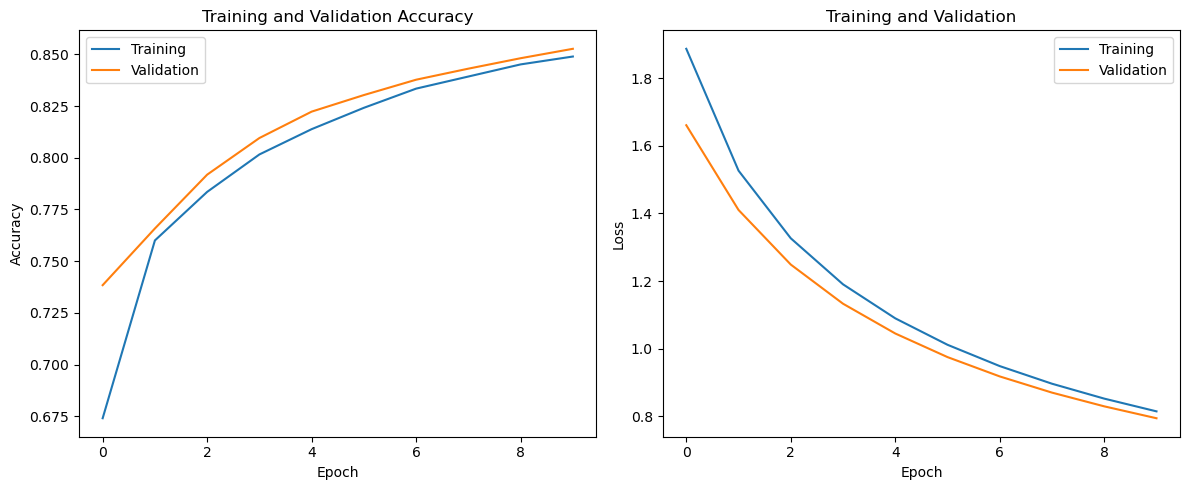

In [202]:
plotAccLoss(history1_Adagrad)

## Model withh more hidden layer


### Model FFNN 
- More hidden 

In [203]:
class FFNN_new(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN_new, self).__init__()

        # Linear function 1: input_dim --> hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: hidden_dim --> hidden_dim
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3: hidden_dim --> hidden_dim
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        
        # Non-linearity 3
        self.relu3 = nn.ReLU()

        # Linear function 4 (readout): hidden_dim --> output_dim
        self.fc4 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.relu3(out)

        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        images = images.reshape(-1, 784).to(device)  # Flatten the images and move to device
        labels = labels.to(device)  # Move labels to device
        out = self.forward(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.reshape(-1, 784).to(device)  # Flatten the images and move to device
        labels = labels.to(device)  # Move labels to device
        out = self.forward(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))


### SGD

In [204]:
model2_SGD = FFNN_new(input_dim, hidden_dim, output_dim).to(device)

In [205]:
history2_SGD = fit(EPOCH, LR, model2_SGD, train_loader, val_loader, opt_func=torch.optim.SGD)

Epoch [0], train_loss: 2.3042, train_acc: 0.1155, val_loss: 2.3026, val_acc: 0.1228
Epoch [1], train_loss: 2.3021, train_acc: 0.1238, val_loss: 2.3007, val_acc: 0.1313
Epoch [2], train_loss: 2.3001, train_acc: 0.1325, val_loss: 2.2988, val_acc: 0.1405
Epoch [3], train_loss: 2.2982, train_acc: 0.1412, val_loss: 2.2969, val_acc: 0.1519
Epoch [4], train_loss: 2.2963, train_acc: 0.1566, val_loss: 2.2949, val_acc: 0.1721
Epoch [5], train_loss: 2.2943, train_acc: 0.1880, val_loss: 2.2929, val_acc: 0.2032
Epoch [6], train_loss: 2.2921, train_acc: 0.2277, val_loss: 2.2908, val_acc: 0.2486
Epoch [7], train_loss: 2.2899, train_acc: 0.3020, val_loss: 2.2885, val_acc: 0.3488
Epoch [8], train_loss: 2.2874, train_acc: 0.3753, val_loss: 2.2859, val_acc: 0.3945
Epoch [9], train_loss: 2.2847, train_acc: 0.4099, val_loss: 2.2831, val_acc: 0.4189


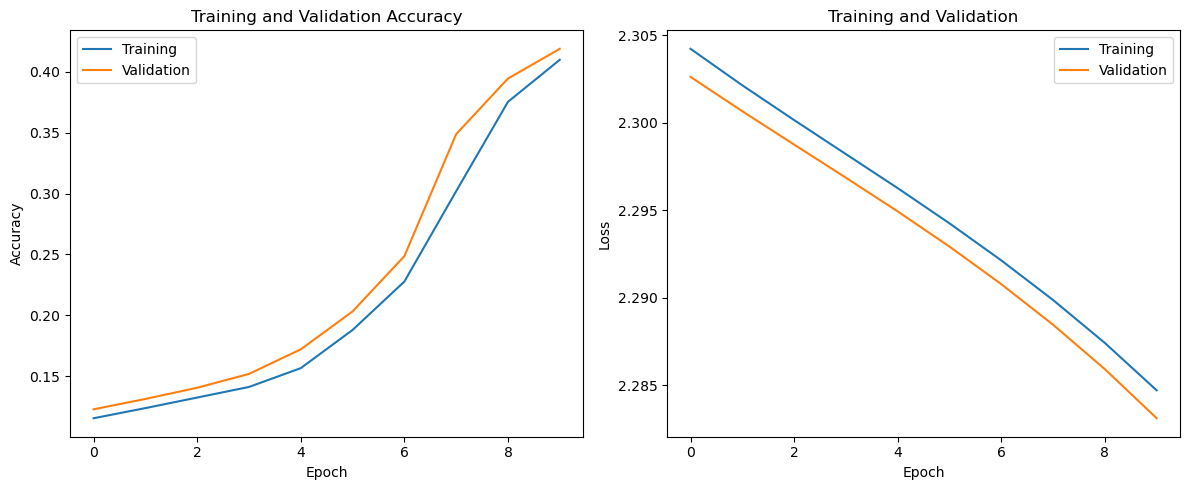

In [206]:
plotAccLoss(history2_SGD)

### momentum

In [207]:
model2_momentum = FFNN_new(input_dim, hidden_dim, output_dim).to(device)

In [208]:
history2_momentum = fit(EPOCH, LR, model2_momentum, train_loader, val_loader, 
                          opt_func=lambda params, lr: SGD(params, lr=lr, momentum=0.9))

Epoch [0], train_loss: 2.2931, train_acc: 0.1439, val_loss: 2.2773, val_acc: 0.3305
Epoch [1], train_loss: 2.2359, train_acc: 0.4023, val_loss: 2.1588, val_acc: 0.4398
Epoch [2], train_loss: 1.8471, train_acc: 0.4732, val_loss: 1.3656, val_acc: 0.6094
Epoch [3], train_loss: 0.9912, train_acc: 0.7218, val_loss: 0.7554, val_acc: 0.7825
Epoch [4], train_loss: 0.6488, train_acc: 0.8126, val_loss: 0.5632, val_acc: 0.8389
Epoch [5], train_loss: 0.5107, train_acc: 0.8548, val_loss: 0.4735, val_acc: 0.8630
Epoch [6], train_loss: 0.4432, train_acc: 0.8725, val_loss: 0.4280, val_acc: 0.8753
Epoch [7], train_loss: 0.4058, train_acc: 0.8838, val_loss: 0.3955, val_acc: 0.8850
Epoch [8], train_loss: 0.3797, train_acc: 0.8908, val_loss: 0.3741, val_acc: 0.8923
Epoch [9], train_loss: 0.3588, train_acc: 0.8966, val_loss: 0.3579, val_acc: 0.8978


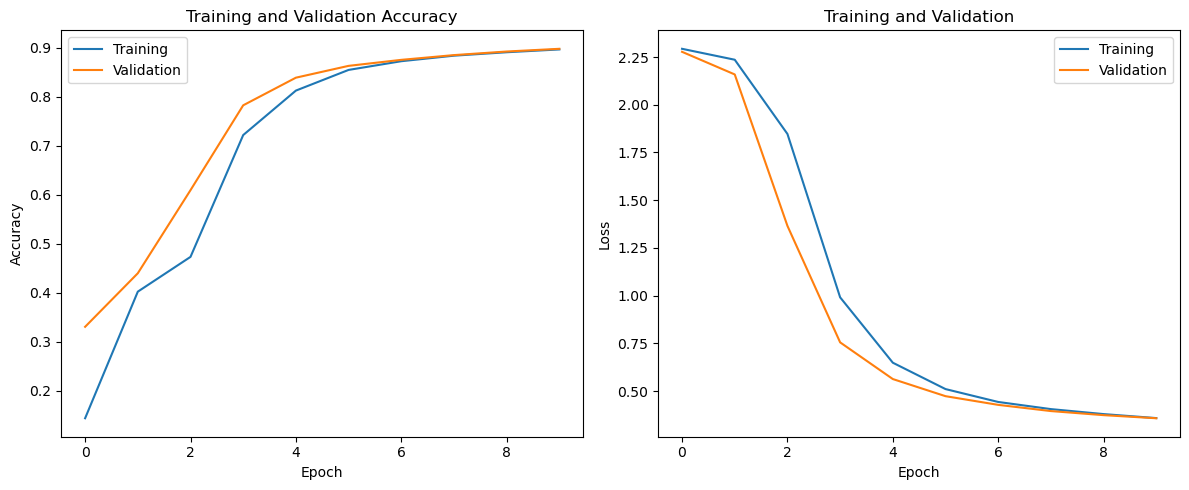

In [209]:
plotAccLoss(history2_momentum)

### Adam

In [210]:
model2_Adam = FFNN_new(input_dim, hidden_dim, output_dim).to(device)

In [211]:
history2_Adam = fit(EPOCH, LR, model2_Adam, train_loader, val_loader, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 0.4781, train_acc: 0.8573, val_loss: 0.2395, val_acc: 0.9302
Epoch [1], train_loss: 0.1931, train_acc: 0.9424, val_loss: 0.1632, val_acc: 0.9516
Epoch [2], train_loss: 0.1319, train_acc: 0.9608, val_loss: 0.1292, val_acc: 0.9633
Epoch [3], train_loss: 0.0992, train_acc: 0.9702, val_loss: 0.1205, val_acc: 0.9651
Epoch [4], train_loss: 0.0801, train_acc: 0.9749, val_loss: 0.1088, val_acc: 0.9669
Epoch [5], train_loss: 0.0672, train_acc: 0.9789, val_loss: 0.0990, val_acc: 0.9723
Epoch [6], train_loss: 0.0555, train_acc: 0.9826, val_loss: 0.0987, val_acc: 0.9700
Epoch [7], train_loss: 0.0456, train_acc: 0.9859, val_loss: 0.1018, val_acc: 0.9705
Epoch [8], train_loss: 0.0383, train_acc: 0.9875, val_loss: 0.0907, val_acc: 0.9751
Epoch [9], train_loss: 0.0331, train_acc: 0.9892, val_loss: 0.0941, val_acc: 0.9746


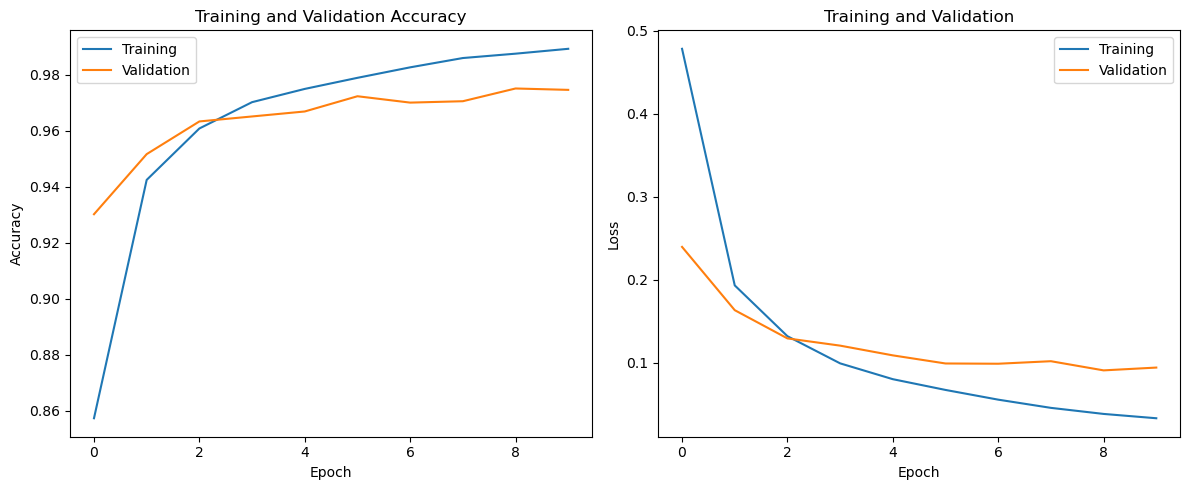

In [212]:
plotAccLoss(history2_Adam)

### RMSprop

In [213]:
model2_RMSprop = FFNN_new(input_dim, hidden_dim, output_dim).to(device)

In [214]:
history2_RMSproop = fit(EPOCH, LR, model2_RMSprop, train_loader, val_loader, opt_func=torch.optim.RMSprop)

Epoch [0], train_loss: 0.3473, train_acc: 0.8911, val_loss: 0.2194, val_acc: 0.9361
Epoch [1], train_loss: 0.1488, train_acc: 0.9549, val_loss: 0.1357, val_acc: 0.9612
Epoch [2], train_loss: 0.1059, train_acc: 0.9673, val_loss: 0.1058, val_acc: 0.9708
Epoch [3], train_loss: 0.0808, train_acc: 0.9750, val_loss: 0.0994, val_acc: 0.9700
Epoch [4], train_loss: 0.0639, train_acc: 0.9798, val_loss: 0.1012, val_acc: 0.9696
Epoch [5], train_loss: 0.0525, train_acc: 0.9833, val_loss: 0.1084, val_acc: 0.9696
Epoch [6], train_loss: 0.0413, train_acc: 0.9868, val_loss: 0.1120, val_acc: 0.9719
Epoch [7], train_loss: 0.0346, train_acc: 0.9889, val_loss: 0.0935, val_acc: 0.9732
Epoch [8], train_loss: 0.0290, train_acc: 0.9904, val_loss: 0.0908, val_acc: 0.9769
Epoch [9], train_loss: 0.0247, train_acc: 0.9918, val_loss: 0.0959, val_acc: 0.9748


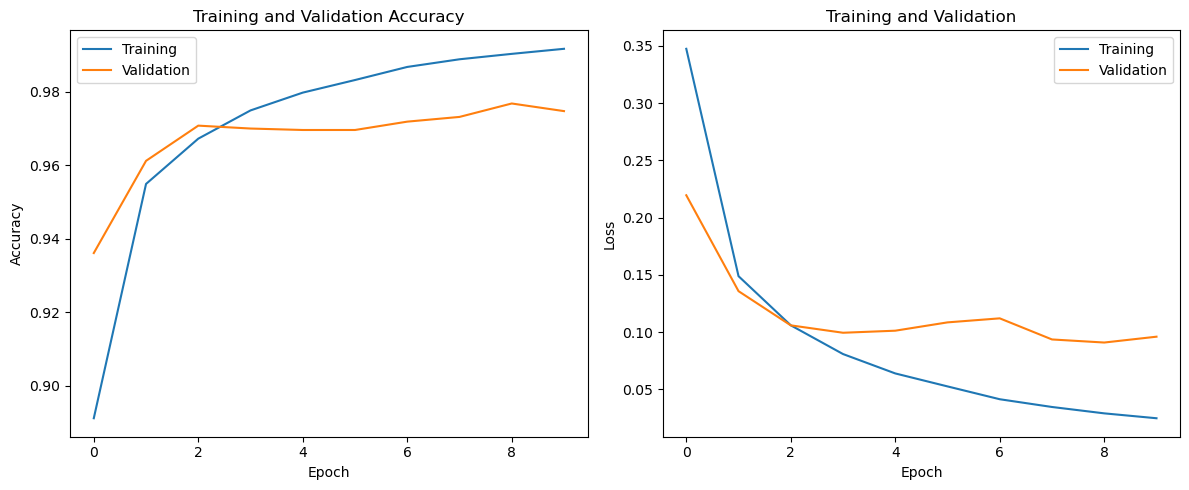

In [215]:
plotAccLoss(history2_RMSproop)

### Adagrad

In [216]:
model2_Adagrad = FFNN_new(input_dim, hidden_dim, output_dim).to(device)

In [217]:
history2_Adagrad = fit(EPOCH, LR, model2_Adagrad, train_loader, val_loader, opt_func=torch.optim.Adagrad)

Epoch [0], train_loss: 1.0185, train_acc: 0.7573, val_loss: 0.5714, val_acc: 0.8528
Epoch [1], train_loss: 0.4998, train_acc: 0.8677, val_loss: 0.4472, val_acc: 0.8775
Epoch [2], train_loss: 0.4222, train_acc: 0.8844, val_loss: 0.3993, val_acc: 0.8891
Epoch [3], train_loss: 0.3869, train_acc: 0.8923, val_loss: 0.3756, val_acc: 0.8968
Epoch [4], train_loss: 0.3660, train_acc: 0.8971, val_loss: 0.3588, val_acc: 0.9018
Epoch [5], train_loss: 0.3513, train_acc: 0.9011, val_loss: 0.3470, val_acc: 0.9031
Epoch [6], train_loss: 0.3402, train_acc: 0.9040, val_loss: 0.3376, val_acc: 0.9063
Epoch [7], train_loss: 0.3310, train_acc: 0.9060, val_loss: 0.3298, val_acc: 0.9070
Epoch [8], train_loss: 0.3232, train_acc: 0.9084, val_loss: 0.3238, val_acc: 0.9082
Epoch [9], train_loss: 0.3165, train_acc: 0.9104, val_loss: 0.3186, val_acc: 0.9104


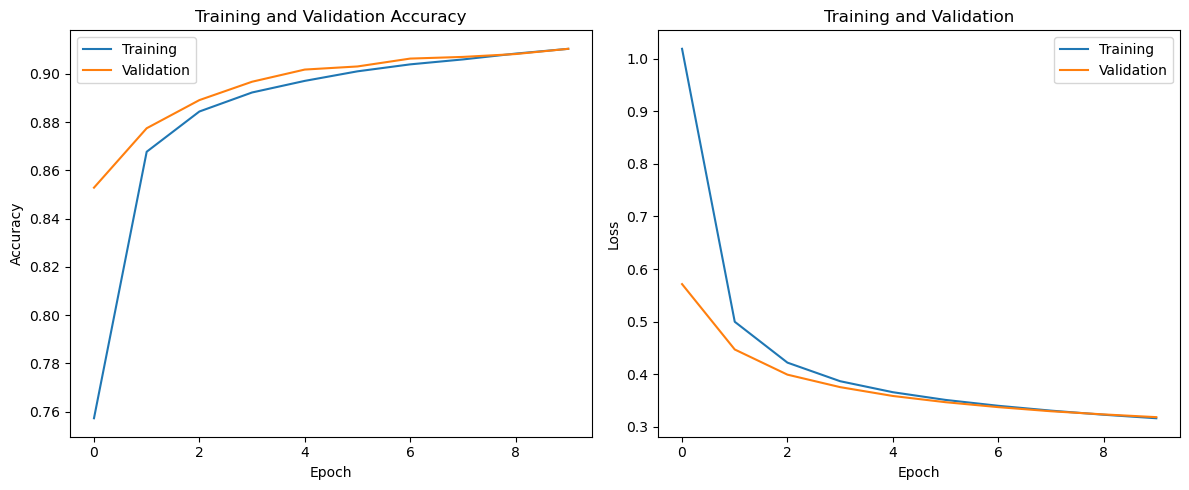

In [218]:
plotAccLoss(history2_Adagrad)

## Test

In [230]:
## Define the test dataset
test_dataset = MNIST(root = 'data/', train = False, transform = transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [226]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

shape:  torch.Size([1, 28, 28])
Label:  7


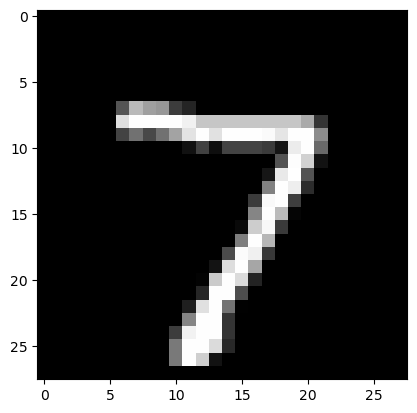

In [220]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap = 'gray')
print("shape: ", img.shape)
print('Label: ', label)

In [231]:
# Function to evaluate model on test dataset
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    test_accs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 784).to(device)  # Flatten the images
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            acc = (predicted == labels).sum().item() / labels.size(0)
            test_accs.append(acc)
    avg_test_acc = sum(test_accs) / len(test_accs)
    print(f'Average Test Accuracy: {avg_test_acc:.4f}')


In [232]:
# Assuming model2_Adagrad, test_dataset, and test_loader are already defined
test_model(model2_Adagrad, test_loader)


Average Test Accuracy: 0.9111


In [245]:
# Assuming model2_Adagrad, test_dataset, and test_loader are already defined
test_model(model2_Adam, test_loader)


Average Test Accuracy: 0.9722


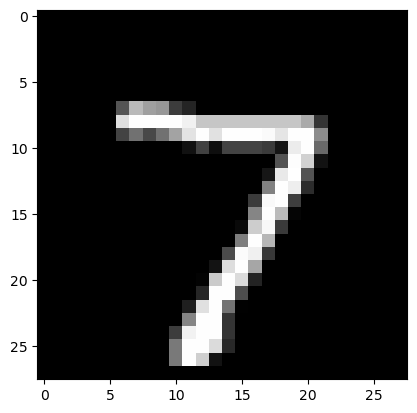

In [233]:
# Load test dataset
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Select an image and its label
img, label = test_dataset[0]

# Plot the image
plt.imshow(img[0], cmap='gray')
plt.show()




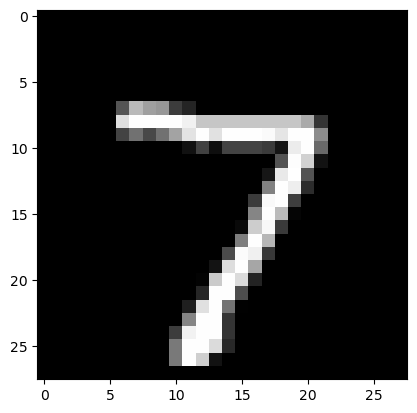

Predicted label: 7
tensor([[-0.1459,  0.0699, -0.0313,  0.0025,  0.0238, -0.1672, -0.0860,  0.2974,
         -0.0895,  0.0565]], device='cuda:0')


In [239]:
# Load test dataset
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Select an image and its label
img, label = test_dataset[0]

# Plot the image
plt.imshow(img[0], cmap='gray')
plt.show()

# Reshape and move image to device
img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device
img_flat = img.view(-1, 28*28)  # Flatten the image to a 1D vector

# Predict with the model
model2_Adagrad.eval()
with torch.no_grad():
    outputs = model(img_flat)
    _, predicted = torch.max(outputs, 1)

# Print prediction
print("Predicted label:", predicted.item())
print(outputs)


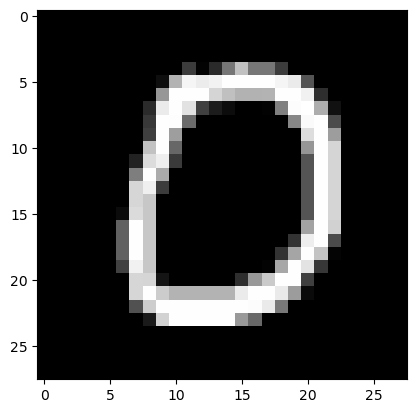

Predicted label: 0
tensor([[ 0.4544, -0.1362,  0.0121,  0.0946, -0.2066,  0.0404, -0.1076, -0.1618,
          0.0012, -0.2454]], device='cuda:0')


In [241]:
# Select an image and its label
img8, label = test_dataset[10]

# Plot the image
plt.imshow(img8[0], cmap='gray')
plt.show()

# Reshape and move image to device
img8 = img8.unsqueeze(0).to(device)  # Add batch dimension and move to device
img8_flat = img8.view(-1, 28*28)  # Flatten the image to a 1D vector

# Predict with the model
model2_Adagrad.eval()
with torch.no_grad():
    outputs = model(img8_flat)
    _, predicted = torch.max(outputs, 1)

# Print prediction
print("Predicted label:", predicted.item())
print(outputs)


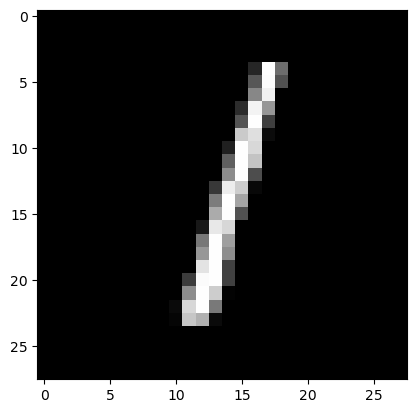

Predicted label: 1
Predicted label: 1
tensor([[-0.1924,  0.4132,  0.0340, -0.0671, -0.0714, -0.0831, -0.0976,  0.0588,
         -0.0585, -0.0333]], device='cuda:0')


In [252]:
# Select an image and its label
img22, label = test_dataset[2]

# Plot the image
plt.imshow(img22[0], cmap='gray')
plt.show()

# Reshape and move image to device
img22 = img22.unsqueeze(0).to(device)  # Add batch dimension and move to device
img22_flat = img22.view(-1, 28*28)  # Flatten the image to a 1D vector

# Predict with the model
model2_Adam.eval()
with torch.no_grad():
    outputs = model(img22_flat)
    _, predicted = torch.max(outputs, 1)

# Print prediction
print("Predicted label:", predicted.item())
print("Predicted label:", label)
print(outputs)


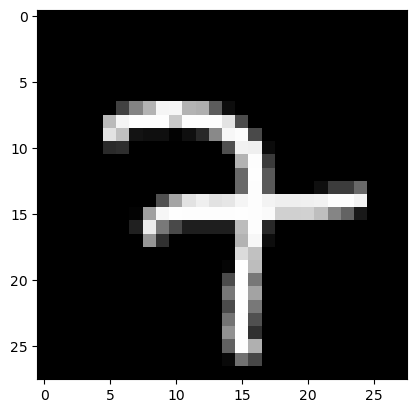

Predicted label: 7
Predicted label: 7
tensor([[-0.2331,  0.0819, -0.0892,  0.0262,  0.0894, -0.2200,  0.0113,  0.1163,
         -0.0984,  0.0935]], device='cuda:0')


In [257]:
# Select an image and its label
img22, label = test_dataset[243]

# Plot the image
plt.imshow(img22[0], cmap='gray')
plt.show()

# Reshape and move image to device
img22 = img22.unsqueeze(0).to(device)  # Add batch dimension and move to device
img22_flat = img22.view(-1, 28*28)  # Flatten the image to a 1D vector

# Predict with the model
model2_Adam.eval()
with torch.no_grad():
    outputs = model(img22_flat)
    _, predicted = torch.max(outputs, 1)

# Print prediction
print("Predicted label:", predicted.item())
print("Predicted label:", label)
print(outputs)
